In [ ]:
from yfinance import download # Stock dataset
from pandas import DataFrame # For DataFrames
from math import log2
from matplotlib import pyplot as plt # For visualization
from sklearn.svm import SVR # Support Vector Machine (Regression)
from sklearn.ensemble import RandomForestRegressor # Random Forest Regression
from sklearn.neural_network import MLPRegressor # For Artifical Neural Network
from keras.layers import LSTM, Embedding, Dropout, Dense, Bidirectional # LSTM layer
from keras.models import Sequential # Sequential model
from sklearn.model_selection import GridSearchCV # For best model fit
from sklearn.preprocessing import StandardScaler # Scaler to convert to 0 mean an unit variance
from numpy import array, mean, append
from keras.preprocessing.sequence import TimeseriesGenerator # To generate input to LSTM


In [ ]:
raw = DataFrame(download("AAPL", period="2y", interval="1d")) # downloading data from yfinance and store as a DataFrame
raw.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-29,136.470001,137.070007,132.449997,133.479996,131.892380,151101000
2021-04-30,131.779999,133.559998,131.070007,131.460007,129.896408,109839500
2021-05-03,132.039993,134.070007,131.830002,132.539993,130.963562,75135100
2021-05-04,131.190002,131.490005,126.699997,127.849998,126.329346,137564700
2021-05-05,129.199997,130.449997,127.970001,128.100006,126.576370,84000900


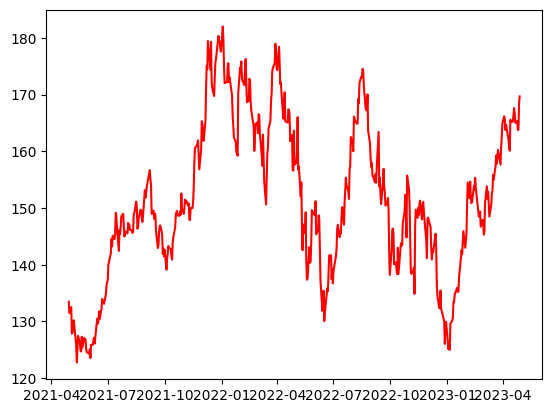

In [ ]:
data = raw['Close'] # Training and testing only on Close prices
plt.plot(data,'r')


In [ ]:
data

Date
2021-04-29    133.479996
2021-04-30    131.460007
2021-05-03    132.539993
2021-05-04    127.849998
2021-05-05    128.100006
                 ...    
2023-04-24    165.330002
2023-04-25    163.770004
2023-04-26    163.759995
2023-04-27    168.410004
2023-04-28    169.679993
Name: Close, Length: 504, dtype: float64

In [ ]:
test_days = int(0.2*len(data)) # 20 % data for testing
feat_days = 31 # Looking for past 31 days of data
# Making the dataset for SVM, NN and RF
# Taking last 31 values as input features and own value as output
test_out = data[-test_days:].values
train_feat,test_feat = [],[]
train_out = data[feat_days+1:-test_days].values
test_out = data[-test_days:].values
for i in range(test_days):
  test_feat.append(data[i-(test_days+feat_days):i-test_days].values)
for i in range(len(train_out)):
  train_feat.append(data[i:i+feat_days].values)
train_feat = array(train_feat)
test_feat = array(test_feat)
# Converting the dataset to mean 0 and unit variance
sc_feat = StandardScaler()
sc_out = StandardScaler()
train_x = sc_feat.fit_transform(train_feat)
test_x = sc_feat.fit_transform(test_feat)
train_y = sc_out.fit_transform(train_out.reshape(-1,1)).squeeze()
test_y = sc_out.fit_transform(test_out.reshape(-1,1)).squeeze()


For SVM
best_score :  10.395217979121307
best_params :  {'C': 16, 'epsilon': 0.001953125, 'gamma': 0.0009765625}


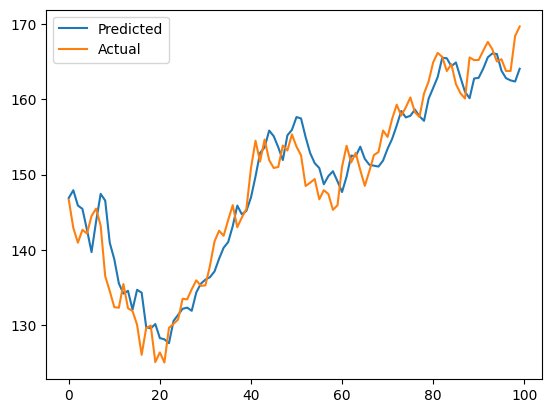

In [ ]:
print("For SVM")
reg = GridSearchCV(SVR(kernel='rbf'),{'C' : [2**i for i in range(-5,5)], 'epsilon' : [2**(-i) for i in range(5,11)], 'gamma' : [2**i for i in range(-10,5)]},
    cv=5,scoring='neg_mean_squared_error') # GridSearchCV
reg.fit(train_x,train_y) # Fit on training data : features and outputs
pred_out = reg.predict(test_x)
pred_out = sc_out.inverse_transform(pred_out.reshape(-1,1)).squeeze()
print('best_score : ',mean((pred_out-test_out)**2))
print('best_params : ',reg.best_params_)
plt.plot(pred_out)
plt.plot(test_out)
plt.legend(['Predicted','Actual'])


For NN
best_score :  13.954952448091724
best_params :  {'alpha': 0.5, 'hidden_layer_sizes': [14, 10]}


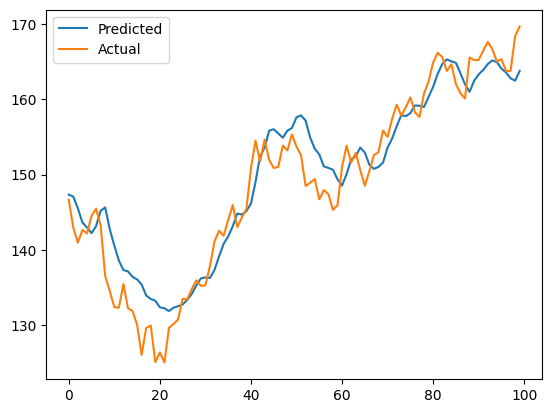

In [ ]:
print("For ANN")
reg = GridSearchCV(MLPRegressor(random_state=10,max_iter=1000,batch_size=10),{'alpha':[0,0.1,0.5,0.7,0.9],'hidden_layer_sizes':[[i, j] for i in range(5,16) for j in range(5,13)]},
    cv=5,scoring='neg_mean_squared_error') # GridSearchCV
reg.fit(train_x,train_y) # Fit on training data : features and outputs
pred_out = reg.predict(test_x)
pred_out = sc_out.inverse_transform(pred_out.reshape(-1,1)).squeeze()
print('best_score : ',mean((pred_out-test_out)**2))
print('best_params : ',reg.best_params_)
plt.plot(pred_out)
plt.plot(test_out)
plt.legend(['Predicted','Actual'])


For RF
best_score :  11.403967242016464
best_params :  {'n_estimators': 1000}


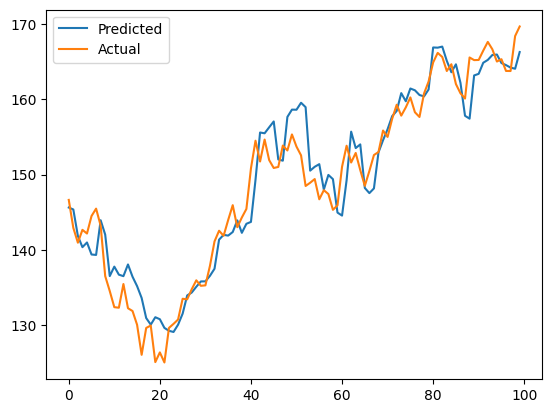

In [ ]:
print("For RF")
reg = GridSearchCV(RandomForestRegressor(random_state=10),{'n_estimators':[100*i for i in range(1,11)]},cv=5,scoring='neg_mean_squared_error') # GridSearchCV
reg.fit(train_x,train_y) # Fit on training data : features and outputs
pred_out = reg.predict(test_x)
pred_out = sc_out.inverse_transform(pred_out.reshape(-1,1)).squeeze()
print('best_score : ',mean((pred_out-test_out)**2))
print('best_params : ',reg.best_params_)
plt.plot(pred_out)
plt.plot(test_out)
plt.legend(['Predicted','Actual'])


For LSTM
Epoch 1/100
373/373 [==============================] - 18s 31ms/step - loss: 0.1729 - mean_absolute_error: 0.3176
Epoch 2/100
373/373 [==============================] - 12s 33ms/step - loss: 0.1010 - mean_absolute_error: 0.2449
Epoch 3/100
373/373 [==============================] - 11s 31ms/step - loss: 0.0775 - mean_absolute_error: 0.2173
Epoch 4/100
373/373 [==============================] - 11s 31ms/step - loss: 0.0689 - mean_absolute_error: 0.2023
Epoch 5/100
373/373 [==============================] - 11s 30ms/step - loss: 0.0622 - mean_absolute_error: 0.1927
Epoch 6/100
373/373 [==============================] - 11s 28ms/step - loss: 0.0597 - mean_absolute_error: 0.1882
Epoch 7/100
373/373 [==============================] - 11s 30ms/step - loss: 0.0541 - mean_absolute_error: 0.1802
Epoch 8/100
373/373 [==============================] - 11s 30ms/step - loss: 0.0580 - mean_absolute_error: 0.1869
Epoch 9/100
373/373 [==============================] - 12s 33ms/step - loss: 0.

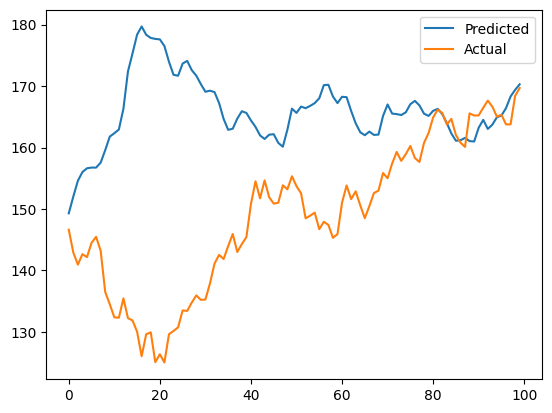

In [ ]:
# Ref = https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

print("For LSTM")
sc = StandardScaler()
train = sc.fit_transform(data[:-test_days].values.reshape(-1, 1) )
test = sc.transform(data[-test_days:].values.reshape(-1, 1) )
n_in = 31
n_feat = 1
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (n_in,n_feat)))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
gen = TimeseriesGenerator(train,train,length=n_in,batch_size=1) # Using in-built generator to generate dataset for LSTM

model.fit(gen,epochs=100)
pred_out = []

first_eval_batch = train[-n_in:]
current_batch = first_eval_batch.reshape((1, n_in, n_feat))

for i in range(len(test)):
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    # append the prediction into the array
    pred_out.append(current_pred) 
    # use the prediction to update the batch and remove the first value
    current_batch = append(current_batch[:,1:,:],[[current_pred]],axis=1)
pred_out = sc.inverse_transform(pred_out)
print('best_score : ',mean((pred_out-test_out)**2))
plt.plot(pred_out)
plt.plot(test_out)
plt.legend(['Predicted','Actual'])
